In [241]:
import boto3
import datetime
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import re
import sagemaker
import seaborn as sns
import time
from time import gmtime, strftime

In [117]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = boto3.Session().region_name

from botocore.config import Config

config = Config(retries={"max_attempts": 10, "mode": "adaptive"})

iam = boto3.client("iam", config=config)

# Getting Our Role Name of LabRole:
role_name = role.split("/")[-1]

print("Role name: {}".format(role_name))

# Checking permissions of our role:
admin = False
post_policies = iam.list_attached_role_policies(RoleName=role_name)["AttachedPolicies"]
for post_policy in post_policies:
    if post_policy["PolicyName"] == "AdministratorAccess":
        admin = True
        setup_iam_roles_passed = True
        print("[OK]")
        break
    else:
        print("*************** [ERROR] SageMakerExecutionRole needs the AdministratorAccess policy attached. *****************")

Role name: LabRole
*************** [ERROR] SageMakerExecutionRole needs the AdministratorAccess policy attached. *****************
*************** [ERROR] SageMakerExecutionRole needs the AdministratorAccess policy attached. *****************
[OK]


In [118]:
# Start with Creation of the S3 Bucket

s3 = boto3.Session().client(service_name="s3", region_name=region)

setup_s3_bucket_passed = False

print("Default bucket: {}".format(bucket))

Default bucket: sagemaker-us-east-1-380520067514


In [119]:
%%bash

aws s3 ls s3://${bucket}/

2022-04-07 19:46:45 sagemaker-studio-380520067514-grja9c0au5
2022-04-07 20:01:59 sagemaker-us-east-1-380520067514


In [120]:
from botocore.client import ClientError

response = None

try:
    response = s3.head_bucket(Bucket=bucket)
    print(response)
    setup_s3_bucket_passed = True
except ClientError as e:
    print("[ERROR] Cannot find bucket {} in {} due to {}.".format(bucket, response, e))

{'ResponseMetadata': {'RequestId': 'DCFHPSNZJFDGGQ8W', 'HostId': 'N122LVHKXjVY4xKqoYquR4W3wN7CoR2VMtmA1S+lSbFZbZbp+mThKuHq1b5wf3w4F52fdRtS6ak=', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': 'N122LVHKXjVY4xKqoYquR4W3wN7CoR2VMtmA1S+lSbFZbZbp+mThKuHq1b5wf3w4F52fdRtS6ak=', 'x-amz-request-id': 'DCFHPSNZJFDGGQ8W', 'date': 'Tue, 19 Apr 2022 17:25:24 GMT', 'x-amz-bucket-region': 'us-east-1', 'x-amz-access-point-alias': 'false', 'content-type': 'application/xml', 'server': 'AmazonS3'}, 'RetryAttempts': 0}}


In [121]:
input(f'Please upload "Raw" folder into default S3 bucket @ {bucket}')

Please upload "Raw" folder into default S3 bucket @ sagemaker-us-east-1-380520067514 m


'm'

Please upload FOUNDATION FOLDER into Default Bucket.

In [139]:
s3_bucket = pd.DataFrame.from_dict(s3.list_objects(Bucket=bucket)['Contents'])

s3_bucket.head(3)

,Key,LastModified,ETag,Size,StorageClass,Owner
0,Raw Data/Other/Vehicle Population.xlsx,2022-04-19 17:11:26+00:00,"""4f3900c67ade80b1aeda1e442e3f5fc8""",4505892,STANDARD,{'DisplayName': 'awslabsc0w3147735t1637051260'...
1,Raw Data/Other/Zip_Codes_by_Court_District_GRO...,2022-04-19 17:11:21+00:00,"""0015ee6491be2eabfb9d3956f8ac6be1""",5939,STANDARD,{'DisplayName': 'awslabsc0w3147735t1637051260'...
2,Raw Data/Other/Zipcode per Location.xlsx,2022-04-19 17:11:22+00:00,"""bf7cea4d4afdd2a670b477ad5b1e5ba4""",9612,STANDARD,{'DisplayName': 'awslabsc0w3147735t1637051260'...


In [140]:
# Base directories
root = '/root/'
raw = 'Raw Data/'
clean = 'Clean/'

extensions = ['.csv', '.pdf', '.xlsx', '.py', '.ipynb']

# create class dir
clean_dir = root + clean
os.mkdir(clean_dir)
os.chdir(clean_dir)

for index, row in s3_bucket.iterrows():
    file_dir = row['Key']
    
    # print every 10th index
    if index % 50 == 0:
        print(f'Processing {index}/{s3_bucket.shape[0]}')
        
    # dir_comprehension
    dir_comp = []

    dir_comp.append('/root')
    
    folder_dir = file_dir.split('/')

    for dir_ in folder_dir:
        # slowly rebuild folder directory 
        dir_comp.append(dir_)

        # The following checks if path exists
        current_dir_path = os.path.join(*dir_comp)
        
        
        # only create paths for non extension files
        if any(ext in current_dir_path for ext in extensions) != True:
            if os.path.isdir(current_dir_path) == False:
                os.mkdir(current_dir_path)
                os.chdir(current_dir_path)
        else:            
            # remove file_name.ext from current_dir_path by the following:
            # break down path into list 
            dir_path = current_dir_path.split('/')
            
            # get last element file_name.ext
            file_name = dir_path.pop()
            
            # rebuild list back to path
            dir_path = '/' + os.path.join(*dir_path)
            
            if (dir_path== os.getcwd()) != True:
                # aws needs root to be encased in '/'
                os.chdir(dir_path)
                
            # checks if file is one of the accepted extensions
            if any(ext in current_dir_path for ext in extensions) == True:
                s3.download_file(Bucket=bucket, Filename=file_name, Key=file_dir)  
                
    # complete
print('Ingestion is complete!')

Processing 0/942
Processing 50/942
Processing 100/942
Processing 150/942
Processing 200/942
Processing 250/942
Processing 300/942
Processing 350/942
Processing 400/942
Processing 450/942
Processing 500/942
Processing 550/942
Processing 600/942
Processing 650/942
Processing 700/942
Processing 750/942
Processing 800/942
Processing 850/942
Processing 900/942
Ingestion is complete!


# Data Processing

## Census DataPrep

In [141]:
# directories
clean = 'Clean/'
raw = 'Raw Data/'
root = '/root/'

# Zip Code Ground Truth
San Diego COUNTY Zip Code list is from [sdcourt.ca.gov/sdcourt/familyandchildren2/wheretofile/zipcodedirectory](https://www.sdcourt.ca.gov/sdcourt/familyandchildren2/wheretofile/zipcodedirectory).

<br><br>
**Zip Code Ground Truth will be utilize to filter out any unnecessary Zip Codes from other Data Tables.**

PDF was processed via Google Colab due to Java dependencies of AWS Sagemaker.

In [142]:
# read in GROUND TRUTH
# S3 PATH
file_path = root + raw + 'Other/' + 'Zip_Codes_by_Court_District_GROUND_TRUTH.csv'
official_zip_code_df = pd.read_csv(file_path)
official_zip_codes = official_zip_code_df['ZIP CODE']
official_zip_codes[:3]

0    91901.0
1    91902.0
2    91903.0
Name: ZIP CODE, dtype: float64

# Census Data

### Read in Cencus Population Data

In [162]:
# S3 PATH
folder_path = root +  raw + 'Population/'
files = os.listdir(folder_path)

dfs = []

for file_ in files:
    file_path = folder_path + file_

    pop_df = pd.read_excel(file_path, sheet_name='Data')

    # remove first column of Label/Total
    pop_df = pop_df.iloc[:,1:]

    zip_data = []
    # loop through multiple of 2 columns per loop
    pop_df_lenght = pop_df.shape[1]

    indices = list(range(0,pop_df_lenght+1,2))
    for i in range(len(indices)):
        # @ end of for loop will throw an OUT OF RANGE error due to max_
        try:
            min_ = indices[i]
            max_ = indices[i+1]

            # focus on 3x2 dataframe of all related to zipcode data
            focus_df = pop_df.iloc[:,min_:max_]

            # list to store data
            row = []
            # get row Zip Code
            zipcode = focus_df.iloc[1,0].split(' ')[1]
            zipcode = zipcode.split('!!')[0]
            row.append(zipcode)

            # gather zip code data
            data = list(focus_df.iloc[2,:])
            # get row pop esimate
            row.append(data[0])
            # get row pop Margine Error
            row.append(data[1])

            # append data to master list
            zip_data.append(row)
        except:
            pass
 

    df = pd.DataFrame(zip_data, columns=['Zip', 'Est', 'MOE'])

    char_num = file_path.find('ACSDT5Y')
    year_string = file_path[char_num:].split('.')[0]
    year_string = year_string.split('Y')[1]

    df['Year'] = year_string

    dfs.append(df)

pop_df = pd.concat(dfs)
pop_df = pop_df.reset_index(drop=True)
pop_df.head(3)

,Zip,Est,MOE,Year
0,91901,"17,034",±968,2012
1,91902,"17,659","±1,031",2012
2,91905,"1,088",±441,2012


In [165]:
set(pop_df['Year'])

{'2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020'}

## Data Cleanup

### Convert Census columns to Int

In [166]:
pop_df['Zip'] = pop_df['Zip'].str.replace('ZCTA5', '')
pop_df.head(3)

,Zip,Est,MOE,Year
0,91901,"17,034",±968,2012
1,91902,"17,659","±1,031",2012
2,91905,"1,088",±441,2012


In [167]:
# remove unwanted chars
pop_df['Est'] = pop_df['Est'].str.replace(',', '')

pop_df['MOE'] = pop_df['MOE'].str.replace('±', '')
pop_df['MOE'] = pop_df['MOE'].str.replace(',', '')

print(pop_df.dtypes, '\n')
pop_df.head(3)

Zip     object
Est     object
MOE     object
Year    object
dtype: object 



,Zip,Est,MOE,Year
0,91901,17034,968,2012
1,91902,17659,1031,2012
2,91905,1088,441,2012


In [168]:
# remove unwanted chars
pop_df['Est'] = pop_df['Est'].str.replace(',', '')

pop_df['MOE'] = pop_df['MOE'].str.replace('±', '')
pop_df['MOE'] = pop_df['MOE'].str.replace(',', '')

print(pop_df.dtypes, '\n')
pop_df.head(3)

Zip     object
Est     object
MOE     object
Year    object
dtype: object 



,Zip,Est,MOE,Year
0,91901,17034,968,2012
1,91902,17659,1031,2012
2,91905,1088,441,2012


In [169]:
pop_df_columns = pop_df.columns

for col in pop_df_columns:
  # print(col)
  pop_df[col] = pop_df[col].astype(int)

pop_df.dtypes

Zip     int64
Est     int64
MOE     int64
Year    int64
dtype: object

### Remove Unwanted Zip Codes from Census

In [170]:
pop_df.shape

(957, 4)

In [171]:
# compare pop_df zip code to official zip codes
pop_df = pop_df[pop_df['Zip'].isin(official_zip_codes)].copy()
pop_df.shape

(957, 4)

In [172]:
pop_df['Zip'].min()

91901

In [173]:
pop_df['Zip'].max()

92173

# Merge Pop W/ Weather Station Location Name
Which will then be merged via SageMaker Data Wrangler

In [176]:
# -- S3 
file_path = root + raw + 'Other/'
zip_code_loc_df = pd.read_excel(file_path+'Zipcode per Location.xlsx')
zip_code_loc_df.head()

,linbergh_field,Campo,Carlsbad,Oceanside Airport,San Diego Mont. Field,Ramona,San Diego Brown Field
0,92152,92021.0,92009.0,92069.0,92123.0,92064.0,91902.0
1,92106,92019.0,92029.0,92083.0,92124.0,92040.0,91910.0
2,92140,91935.0,92024.0,92084.0,92120.0,92065.0,91914.0
3,92107,91901.0,92007.0,92054.0,92119.0,92036.0,91978.0
4,92110,91917.0,92091.0,92055.0,91942.0,91916.0,91913.0


In [177]:
locations = []

for index, row in pop_df.iterrows():
    zip = row['Zip']

    location_boolean = zip_code_loc_df.isin([zip]).any()
    location = location_boolean[location_boolean == True].index

    try:
        locations.append(location[0])
    except:
        continue

pop_df['weather_station'] = locations

pop_df.head(3)

,Zip,Est,MOE,Year,weather_station
0,91901,17034,968,2012,Campo
1,91902,17659,1031,2012,San Diego Brown Field
2,91905,1088,441,2012,Campo


In [178]:
clean_data_dir = root + clean

pop_df.to_parquet(clean_data_dir + 'census_pop.parquet.gzip', compression='gzip', index=False)

In [179]:
file_name = 'census_pop.parquet.gzip'
file_path = 'Clean/' + file_name

# Upload flow to S3
s3_client = boto3.client("s3")
s3_client.upload_file(clean_data_dir + file_name, bucket, file_path)

## SDGE DataPrep
Data is from [Data Source](https://energydata.sdge.com/)

In [180]:
def concatenator(base_dir, folder):
  ''' 
  Takes in file directory and specific folder name.
  Returns all files in directory as a single pd.DF   
  '''

  files = os.listdir(base_dir + folder)

  # append all files to
  dfs = []

  # loop over files in folder and append to dfs list
  for file_ in files:
    df = pd.read_csv(os.path.join(base_dir, folder, file_))
    dfs.append(df)

  return pd.concat(dfs, axis=0, ignore_index=True)

## Gas DataPrep

In [181]:
base_sdge_dir = root + raw + 'SDGE/'
folder = 'Gas'
gas_df = concatenator(base_sdge_dir, folder)

print(f'Shape {gas_df.shape}\n', '--'*20)
gas_df.head(3)

Shape (29250, 8)
 ----------------------------------------


,ZipCode,Month,Year,CustomerClass,Combined,TotalCustomers,TotalTherms,AverageTherms
0,91901,10,2019,C,Y,0,0,0
1,91901,10,2019,R,Y,2098,42738,20
2,91902,10,2019,C,Y,0,0,0


In [182]:
gas_df = gas_df[gas_df['ZipCode'].isin(official_zip_codes)].copy()
gas_df.shape

(28548, 8)

In [183]:
# Drop Zip Codes/Rows with 0 Customers
gas_df = gas_df[gas_df['TotalCustomers'] != 0]
gas_df.shape

(13867, 8)

In [184]:
# group by the following to combine commercial & residential consumers into 1 row
gas_df = gas_df.groupby(['ZipCode', 'Year','Month']).sum()
gas_df = gas_df.reset_index()
gas_df.head(3)

,ZipCode,Year,Month,TotalCustomers,TotalTherms,AverageTherms
0,91901,2012,1,2711,148354,292
1,91901,2012,2,2704,138102,283
2,91901,2012,3,2674,159852,309


## Electric DataPrep

In [185]:
base_sdge_dir = root + raw + 'SDGE/'
folder = 'Electric'
elect_df = concatenator(base_sdge_dir, folder)

print(f'Shape {elect_df.shape}\n', '--'*20)

elect_df.head(3)

Shape (68760, 8)
 ----------------------------------------


,ZipCode,Month,Year,CustomerClass,Combined,TotalCustomers,TotalkWh,AveragekWh
0,91901,7,2014,A,Y,0,0,0
1,91901,7,2014,C,Y,775,3912545,5048
2,91901,7,2014,I,Y,0,0,0


In [186]:
elect_df = elect_df[elect_df['ZipCode'].isin(official_zip_codes)].copy()
elect_df.shape

(58560, 8)

In [187]:
# Drop Zip Codes/Rows with 0 Customers
elect_df = elect_df.loc[elect_df['TotalCustomers'] != 0]
elect_df.shape

(19111, 8)

That removed roughly 40k records!

In [188]:
# group by the following to combine commercial & residential consumers into 1 row
elect_df = elect_df.groupby(['ZipCode', 'Year','Month']).sum()
elect_df = elect_df.reset_index()
elect_df.head(3)

,ZipCode,Year,Month,TotalCustomers,TotalkWh,AveragekWh
0,91901,2012,1,595,178335,603
1,91901,2012,2,736,572185,1555
2,91901,2012,3,1866,1180728,1776


### Merge Gas & Electric

In [189]:
sdge_df = pd.merge(gas_df, elect_df, on=['ZipCode', 'Year', 'Month'], suffixes=('_gas','_elect'))
sdge_df.head(3)

,ZipCode,Year,Month,TotalCustomers_gas,TotalTherms,AverageTherms,TotalCustomers_elect,TotalkWh,AveragekWh
0,91901,2012,1,2711,148354,292,595,178335,603
1,91901,2012,2,2704,138102,283,736,572185,1555
2,91901,2012,3,2674,159852,309,1866,1180728,1776


In [190]:
sdge_df.shape

(9420, 9)

#### Save cleaned SDGE file and upload to S3

In [191]:
clean_data_dir = root + clean

sdge_df.to_parquet(clean_data_dir + 'sdge.parquet.gzip', compression='gzip', index=False)

In [192]:
file_name = 'sdge.parquet.gzip'
file_path = 'Clean/' + file_name

# Upload flow to S3
s3_client = boto3.client("s3")
s3_client.upload_file(clean_data_dir + file_name, bucket, file_path)

## Vehicle DataPrep

In [193]:
file_path = root + raw + '/Other/Vehicle Population.xlsx'
veh_df = pd.read_excel(file_path,
                       sheet_name='ZIP')

# print shape
print(f'Shape {veh_df.shape}\n', '--'*20)

veh_df.head(3)

Shape (175291, 4)
 ----------------------------------------


,Data Year,Fuel Type,ZIP,Number of Vehicles
0,2010,Bio Diesel,90010,3
1,2010,Bio Diesel,90019,1
2,2010,Bio Diesel,90047,1


In [194]:
veh_df.rename(columns={'Data Year':'Year',
                        'Fuel Type':'Fuel',
                        'Number of Vehicles':'#_vehicles'},
              inplace=True)

#### Remove unwanted zip codes

In [195]:
veh_df[veh_df['#_vehicles'] == 0]

,Year,Fuel,ZIP,#_vehicles


In [196]:
veh_df.shape

(175291, 4)

In [197]:
veh_df = veh_df[veh_df['ZIP'].isin(official_zip_codes)].copy()
veh_df.shape

(12744, 4)

# Melt Dataframe

In [198]:
years = sorted(set(veh_df['Year']))

dfs = []
for year in years:
    print(f'Processesing {year}', '\n')

    year_df = veh_df.loc[veh_df['Year'] == year]

    zip_codes = set(year_df['ZIP'])

    for zip_code in zip_codes:

        mutate_df = year_df.loc[year_df['ZIP'] == zip_code, ['Fuel', '#_vehicles']]

        indexes = list(mutate_df.T.iloc[0,:])

        mutate_df.index = pd.Index(indexes,name='Fuel')

        mutate_df = mutate_df.T.reset_index(drop=True)

        mutate_df['Year'] = year
        mutate_df['ZIP'] = zip_code

        dfs.append(pd.DataFrame(mutate_df.iloc[1,:]).T)

final_df = pd.concat(dfs)
final_df.head(3)

Processesing 2010 

Processesing 2011 

Processesing 2012 

Processesing 2013 

Processesing 2014 

Processesing 2015 

Processesing 2016 

Processesing 2017 

Processesing 2018 

Processesing 2019 

Processesing 2020 



,Diesel,Flex Fuel,Gasoline,Gasoline Hybrid,Year,ZIP,Natural Gas,Bio Diesel,Propane,Electric,PHEV,Hydrogen
1,7,7,293,8,2010,92160,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,4,NaN,2010,92161,NaN,NaN,NaN,NaN,NaN,NaN
1,5,4,184,2,2010,92162,NaN,NaN,NaN,NaN,NaN,NaN


Index is labeld as "FUEL".  This will be omitted when DataFrame is written to CSV/Parquet.

In [199]:
final_df = final_df.fillna(0)
final_df.head(3)

,Diesel,Flex Fuel,Gasoline,Gasoline Hybrid,Year,ZIP,Natural Gas,Bio Diesel,Propane,Electric,PHEV,Hydrogen
1,7,7,293,8,2010,92160,0,0,0,0,0,0
1,0,0,4,0,2010,92161,0,0,0,0,0,0
1,5,4,184,2,2010,92162,0,0,0,0,0,0


#### Fix Hydrogen column name
Hydrogen column name has an extra space at the end!

In [200]:
final_df = final_df.rename(columns={'Hydrogen ':'Hydrogen'})
final_df.columns

Index(['Diesel', 'Flex Fuel', 'Gasoline', 'Gasoline Hybrid', 'Year', 'ZIP',
       'Natural Gas', 'Bio Diesel', 'Propane', 'Electric', 'PHEV', 'Hydrogen'],
      dtype='object')

## Interpolate for dates missing
Utilizing Linear Padding

In [201]:
final_df.loc[final_df['ZIP'] == 92090].sort_values('Year')

,Diesel,Flex Fuel,Gasoline,Gasoline Hybrid,Year,ZIP,Natural Gas,Bio Diesel,Propane,Electric,PHEV,Hydrogen
1,0,0,6,0,2010,92090,0,0,0,0,0,0
1,0,0,2,0,2011,92090,0,0,0,0,0,0
1,0,0,2,0,2014,92090,0,0,0,0,0,0
1,0,1,1,0,2017,92090,0,0,0,0,0,0
1,0,0,1,0,2019,92090,0,0,0,0,0,0
1,0,0,3,0,2020,92090,0,0,0,0,0,0


In [202]:
dfs = []
zip_check = []
years_needed_list = []
for zip_ in zip_codes:
    interpolate_df = final_df.loc[final_df['ZIP'] == zip_]

    # gather the years from df
    years = set(interpolate_df['Year'])
    # set requirement for years
    needed_years = set(list(np.arange(2010,2022)))

    # get the difference between the two
    years_needed = list(needed_years - years)

    # --- create rows for years needed ---
    # gather the years from df
    years = set(interpolate_df['Year'])
    # set requirement for years
    needed_years = set(list(np.arange(2010,2022)))

    # get the difference between the two
    years_needed = list(needed_years - years)
    
    # check if zip code is missing any crucial years (2010-2020)
    if pd.Series(years_needed).isin(np.arange(2011,2021))[0]:
        zip_check.append(zip_)
        years_needed_list.append(sorted(years_needed))
    
    # create rows for years needed

    for year_needed in years_needed:
        next_row_dict = {
            'Diesel': [np.nan],
            'Flex Fuel': [np.nan],
            'Gasoline': [np.nan],
            'Gasoline Hybrid': [np.nan],
            'Year': [year_needed],
            'ZIP': [zip_],
            'Natural Gas' : [np.nan],
            'Bio Diesel': [np.nan],
            'Propane': [np.nan],
            'Electric': [np.nan],
            'PHEV': [np.nan],
            'Hydrogen': [np.nan]
        }
        next_row_df = pd.DataFrame.from_dict(next_row_dict)
        interpolate_df = pd.concat([interpolate_df, next_row_df])
    
    interpolate_df = interpolate_df.reset_index(drop=True)
    # interpolate for new added years
    interpolate_df = interpolate_df.interpolate(method='linear', axis=0)
    dfs.append(interpolate_df)

final_df = pd.concat(dfs)
final_df.head(3)

,Diesel,Flex Fuel,Gasoline,Gasoline Hybrid,Year,ZIP,Natural Gas,Bio Diesel,Propane,Electric,PHEV,Hydrogen
0,7.0,7.0,293.0,8.0,2010,92160,0.0,0.0,0.0,0.0,0.0,0.0
1,8.0,9.0,305.0,7.0,2011,92160,0.0,0.0,0.0,0.0,0.0,0.0
2,12.0,12.0,330.0,10.0,2012,92160,0.0,0.0,0.0,0.0,1.0,0.0


In [203]:
zip_check

[92187, 91947, 91987, 92090]

In [205]:
years_needed_list

[[2010, 2015, 2016, 2019, 2021],
 [2019, 2021],
 [2011, 2015, 2021],
 [2012, 2013, 2015, 2016, 2018, 2021]]

In [206]:
final_df.loc[final_df['ZIP'] == 92090].sort_values('Year')

,Diesel,Flex Fuel,Gasoline,Gasoline Hybrid,Year,ZIP,Natural Gas,Bio Diesel,Propane,Electric,PHEV,Hydrogen
0,0.0,0.0,6.0,0.0,2010,92090,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,2.0,0.0,2011,92090,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,3.0,0.0,2012,92090,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,3.0,0.0,2013,92090,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,2.0,0.0,2014,92090,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,3.0,0.0,2015,92090,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,3.0,0.0,2016,92090,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,2017,92090,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,3.0,0.0,2018,92090,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,2019,92090,0.0,0.0,0.0,0.0,0.0,0.0


In [207]:
final_df = final_df.reset_index(drop=True)
final_df.head(3)

,Diesel,Flex Fuel,Gasoline,Gasoline Hybrid,Year,ZIP,Natural Gas,Bio Diesel,Propane,Electric,PHEV,Hydrogen
0,7.0,7.0,293.0,8.0,2010,92160,0.0,0.0,0.0,0.0,0.0,0.0
1,8.0,9.0,305.0,7.0,2011,92160,0.0,0.0,0.0,0.0,0.0,0.0
2,12.0,12.0,330.0,10.0,2012,92160,0.0,0.0,0.0,0.0,1.0,0.0


In [208]:
# add count from all columns into 1 named "total_cars"
vehicle_columns = ['Bio Diesel',
                   'Diesel',
                   'Electric',
                   'Flex Fuel',
                   'Gasoline',
                   'Gasoline Hybrid',
                   'Hydrogen',
                   'Natural Gas',
                   'PHEV',
                   'Propane']

final_df['total_cars'] = final_df.loc[:,vehicle_columns].sum(axis=1)
final_df.head(3)

,Diesel,Flex Fuel,Gasoline,Gasoline Hybrid,Year,ZIP,Natural Gas,Bio Diesel,Propane,Electric,PHEV,Hydrogen,total_cars
0,7.0,7.0,293.0,8.0,2010,92160,0.0,0.0,0.0,0.0,0.0,0.0,315.0
1,8.0,9.0,305.0,7.0,2011,92160,0.0,0.0,0.0,0.0,0.0,0.0,329.0
2,12.0,12.0,330.0,10.0,2012,92160,0.0,0.0,0.0,0.0,1.0,0.0,365.0


## Write DF to CSV & Parquet

In [209]:
clean_data_dir = root + clean

final_df.to_parquet(clean_data_dir + 'vehicle_registration.parquet.gzip',
                                   compression='gzip',
                                   index=False)

clean_data_dir = root + clean
final_df.to_csv(clean_data_dir +'vehicle_registration.csv', index=False)

## Upload Files to S3

In [210]:
file_name1 = 'vehicle_registration.parquet.gzip'
file_name2 = 'vehicle_registration.csv'
file_path = 'Clean/' + file_name

s3_client.upload_file(clean_data_dir + file_name1, bucket, file_path)
s3_client.upload_file(clean_data_dir + file_name2, bucket, file_path)

In [211]:
file_name = 'vehicle_registration.parquet.gzip'
file_path = 'Clean/' + file_name

# Upload flow to S3
s3_client.upload_file(clean_data_dir + file_name, bucket, file_path)

## Weather DataPrep

Weather is from https://www.weather.gov/sgx/cliplot

In [212]:
dfs = []

weather_folder_path = root + raw + '/Scraped_Gov_Weather/'
weather_folders = os.listdir(weather_folder_path)

for folder in weather_folders:
  parent_dir = weather_folder_path + folder

  children_folders = os.listdir(parent_dir)

  for child_folder in children_folders:
    child_dir = parent_dir + '/' + f'{child_folder}'
    
    files = os.listdir(child_dir)

    for file_ in files:
      file_path = child_dir + '/' + file_
      df = pd.read_csv(file_path)


      date = df.iloc[0,1]

      # grab only observed lowh/igh, and normal low/high
      df = df.iloc[1:,1:6]

      # make the first row into the column names
      df.rename(columns={'0': df.iloc[0,0],
              '1': df.iloc[0,1],
              '2': df.iloc[0,2],
              '3': df.iloc[0,3],
              '4': df.iloc[0,4]},
              inplace=True)

      # drop first row of column names
      df = df.iloc[1:,:]

      # remove last row which contains Average for each columnd
      del_last_row = df.shape[0] - 1
      df = df.iloc[0:del_last_row,:]

      # write location name from folder variable
      df['location'] = folder

      # get date and assign to columns
      date_list = date.split(' ')[1]
      df['Month'] = date_list.split('/')[0]
      df['Year'] = date_list.split('/')[1]


      dfs.append(df)

weather_df = pd.concat(dfs)
weather_df = weather_df.reset_index(drop=True)
weather_df.head(3)

,Date,ObservedLow(F),ObservedHigh(F),NormalLow(F),NormalHigh(F),location,Month,Year
0,1,52,84,45,84,Campo,10,2016
1,2,44,76,45,84,Campo,10,2016
2,3,33,71,45,84,Campo,10,2016


In [213]:
# change colum names to something easier to work with
weather_df.rename(columns={'ObservedLow(F)': 'Low',
                           'ObservedHigh(F)': 'High',
                           'NormalLow(F)': 'NormLow',
                           'NormalHigh(F)': 'NormHigh'},
                  inplace=True)
                    
weather_df.head(3)

,Date,Low,High,NormLow,NormHigh,location,Month,Year
0,1,52,84,45,84,Campo,10,2016
1,2,44,76,45,84,Campo,10,2016
2,3,33,71,45,84,Campo,10,2016


In [215]:
locations = list(set(weather_df['location']))
locations

['Oceanside Airport',
 'linbergh_field',
 'San Diego Brown Field',
 'San Diego Mont. Field',
 'Carlsbad',
 'Ramona',
 'Campo']

In [216]:
weather_df.describe()

,Date,Low,High,NormLow,NormHigh,location,Month,Year
count,25571,25571,25571,25571,25571,25571,25571,25571
unique,31,66,73,37,34,7,12,10
top,22,M,M,44,66,San Diego Brown Field,01,2020
freq,840,1498,1498,1210,3046,3659,2449,2921


That is interesting, the "top" row (3rd down) has a low and high of M.  Let's fix that.

In [217]:
high_M = weather_df[weather_df['High'] == 'M']
high_M.head()

,Date,Low,High,NormLow,NormHigh,location,Month,Year
31,1,M,M,39,75,Campo,11,2016
32,2,M,M,39,74,Campo,11,2016
33,3,M,M,39,74,Campo,11,2016
34,4,M,M,39,74,Campo,11,2016
35,5,M,M,38,74,Campo,11,2016


In [218]:
# clean up those Ms!
new_low = []
new_high = []

for index, row in weather_df.iterrows():
  
  
  if row['Low'] == 'M':

    if row['NormLow'] == 'M':
      new_low.append(np.nan)
    else:
      new_low.append(row['NormLow'])

  else:
    new_low.append(row['Low'])
  
  
  if row['High'] == 'M':

    if row['NormHigh'] == 'M':
      new_high.append(np.nan)
    else:
      new_high.append(row['NormHigh'])

  else:
    new_high.append(row['High'])


weather_df = weather_df.loc[:,['Date', 'location', 'Month', 'Year']].copy()
weather_df['High'] = new_high
weather_df['Low'] = new_low

weather_df.head(3)

,Date,location,Month,Year,High,Low
0,1,Campo,10,2016,84,52
1,2,Campo,10,2016,76,44
2,3,Campo,10,2016,71,33


In [219]:
weather_df[weather_df['High'] == 'M']

,Date,location,Month,Year,High,Low


In [220]:
weather_df[weather_df['Low'] == 'M']

,Date,location,Month,Year,High,Low


In [221]:
bool_ = weather_df['Low'].isna()

weather_df.loc[bool_,:]

,Date,location,Month,Year,High,Low


In [222]:
bool_ = weather_df['High'].isna()

weather_df.loc[bool_,:]

,Date,location,Month,Year,High,Low


## Data Prep Continuation

In [223]:
weather_df = weather_df.astype({'Date':'int',
                   'Month':'int',
                   'Year':'int',
                   'Low':'int',
                   'High':'int',})

weather_df.dtypes

Date         int64
location    object
Month        int64
Year         int64
High         int64
Low          int64
dtype: object

In [224]:
min_df = weather_df.groupby(by = ['Year', 'Month', 'location']).min()

min_df = min_df.drop(columns=['Date', 'High'])

min_df.head(14)

Low
Year Month location                  
2012 1     Campo                   23
           Carlsbad                41
           Oceanside Airport       31
           Ramona                  22
           San Diego Brown Field   43
           San Diego Mont. Field   38
           linbergh_field          43
     2     Campo                   23
           Carlsbad                40
           Oceanside Airport       34
           Ramona                  27
           San Diego Mont. Field   40
           linbergh_field          46
     3     Campo                   25

In [225]:
min_df.tail(14)

Low
Year Month location                  
2021 10    San Diego Mont. Field   47
           linbergh_field          50
     11    Carlsbad                46
           Oceanside Airport       37
           Ramona                  32
           San Diego Brown Field   42
           San Diego Mont. Field   47
           linbergh_field          45
     12    Carlsbad                40
           Oceanside Airport       31
           Ramona                  22
           San Diego Brown Field   35
           San Diego Mont. Field   38
           linbergh_field          38

In [226]:
max_df = weather_df.groupby(by = ['Year', 'Month', 'location']).max()

max_df = max_df.drop(columns=['Date', 'Low'])

max_df.head(14)

High
Year Month location                   
2012 1     Campo                    81
           Carlsbad                 81
           Oceanside Airport        82
           Ramona                   86
           San Diego Brown Field    77
           San Diego Mont. Field    85
           linbergh_field           83
     2     Campo                    76
           Carlsbad                 80
           Oceanside Airport        79
           Ramona                   79
           San Diego Mont. Field    80
           linbergh_field           75
     3     Campo                    77

In [227]:
max_df.tail(14)

High
Year Month location                   
2021 10    San Diego Mont. Field    95
           linbergh_field           90
     11    Carlsbad                 90
           Oceanside Airport        95
           Ramona                   92
           San Diego Brown Field    91
           San Diego Mont. Field    93
           linbergh_field           92
     12    Carlsbad                 67
           Oceanside Airport        69
           Ramona                   86
           San Diego Brown Field    76
           San Diego Mont. Field    81
           linbergh_field           69

In [228]:
avg_df = weather_df.groupby(by = ['Year', 'Month', 'location']).mean()

avg_df = avg_df.rename(columns={'High':'AvgHigh',
                       'Low':'AvgLow'})

avg_df.head(14)

Date    AvgHigh     AvgLow
Year Month location                                         
2012 1     Campo                  16.0  65.129032  33.774194
           Carlsbad               16.0  67.903226  47.322581
           Oceanside Airport      16.0  68.451613  37.580645
           Ramona                 16.0  70.870968  32.774194
           San Diego Brown Field  16.0  66.225806  44.000000
           San Diego Mont. Field  16.0  70.032258  44.516129
           linbergh_field         16.0  67.354839  49.032258
     2     Campo                  15.0  60.103448  32.413793
           Carlsbad               15.0  63.896552  47.965517
           Oceanside Airport      15.0  65.965517  40.482759
           Ramona                 15.0  65.586207  35.000000
           San Diego Mont. Field  15.0  66.620690  46.379310
           linbergh_field         15.0  64.827586  50.931034
     3     Campo                  16.0  63.612903  32.806452

In [229]:
avg_df.tail(14)

Date    AvgHigh     AvgLow
Year Month location                                         
2021 10    San Diego Mont. Field  16.0  76.580645  56.096774
           linbergh_field         16.0  75.096774  58.419355
     11    Carlsbad               15.5  70.533333  54.100000
           Oceanside Airport      15.5  73.633333  46.966667
           Ramona                 15.5  79.466667  40.200000
           San Diego Brown Field  15.5  75.366667  50.533333
           San Diego Mont. Field  15.5  76.200000  53.633333
           linbergh_field         15.5  73.133333  55.366667
     12    Carlsbad               16.0  60.645161  47.580645
           Oceanside Airport      16.0  63.032258  41.870968
           Ramona                 16.0  63.032258  36.580645
           San Diego Brown Field  16.0  63.645161  45.806452
           San Diego Mont. Field  16.0  63.903226  47.967742
           linbergh_field         16.0  62.322581  48.967742

In [230]:
final_weather_df = pd.merge(min_df, max_df, on = ['Year', 'Month', 'location'])
final_weather_df.head()

Low  High
Year Month location                        
2012 1     Campo                   23    81
           Carlsbad                41    81
           Oceanside Airport       31    82
           Ramona                  22    86
           San Diego Brown Field   43    77

In [231]:
final_weather_df2 = pd.merge(final_weather_df, avg_df, on = ['Year', 'Month', 'location']).reset_index()
final_weather_df2 = final_weather_df2.drop(columns='Date')

final_weather_df2.head(3)

,Year,Month,location,Low,High,AvgHigh,AvgLow
0,2012,1,Campo,23,81,65.129032,33.774194
1,2012,1,Carlsbad,41,81,67.903226,47.322581
2,2012,1,Oceanside Airport,31,82,68.451613,37.580645


In [232]:
date_columns = ['Month','Year']
final_weather_df2['Full_date'] = final_weather_df2.loc[:,date_columns].apply(lambda x: '/'.join(x.values.astype(str)), axis='columns')
final_weather_df2.head(3)

,Year,Month,location,Low,High,AvgHigh,AvgLow,Full_date
0,2012,1,Campo,23,81,65.129032,33.774194,1/2012
1,2012,1,Carlsbad,41,81,67.903226,47.322581,1/2012
2,2012,1,Oceanside Airport,31,82,68.451613,37.580645,1/2012


In [233]:
final_weather_df2['Full_date'] = pd.to_datetime(final_weather_df2['Full_date'])
final_weather_df2.dtypes

Year                  int64
Month                 int64
location             object
Low                   int64
High                  int64
AvgHigh             float64
AvgLow              float64
Full_date    datetime64[ns]
dtype: object

In [234]:
# save to local dir
clean_data_dir = root + clean

final_weather_df2.to_parquet(clean_data_dir + 'weather.parquet.gzip', compression='gzip', index=False)

In [235]:
file_name = 'weather.parquet.gzip'
file_path = 'Clean/' + file_name

# Upload to S3
s3_client.upload_file(clean_data_dir + file_name, bucket, file_path)

# EDA

Before proceeding to manual EDA, the following code block generated Pandas Profiles.  

*NOTE*
Pandas Profile reports are generated outside of SageMaker due to dependency issues with Java

In [ ]:
# from pandas_profiling import ProfileReport

In [ ]:
# data_sets = os.listdir('/root/Clean/')

# for data_set in data_sets:
#     df = pd.read_parquet(data_set)

#     # get data name
#     data_name = data_set.split('.')[0]
    
#     # compile Pandas Profile report
#     print(f'Building {data_name} report.')
#     ProfileReport(df).to_file(f"{data_name}_report.html")
    
#     print('--'*30,)
# print('!!'*10, '----', 'Profiling Complete','-----','!!'*10)

## Census EDA


### Read in Cencus Population Data

In [236]:
pop_df = pop_df.rename(columns={'Est':'Est_Pop'})
pop_df.head(2)

,Zip,Est_Pop,MOE,Year,weather_station
0,91901,17034,968,2012,Campo
1,91902,17659,1031,2012,San Diego Brown Field


In [237]:
pop_df

,Zip,Est_Pop,MOE,Year,weather_station
0,91901,17034,968,2012,Campo
1,91902,17659,1031,2012,San Diego Brown Field
2,91905,1088,441,2012,Campo
3,91906,3679,560,2012,Campo
4,91910,73761,1515,2012,San Diego Brown Field
...,...,...,...,...,...
952,92140,3112,589,2016,linbergh_field
953,92147,569,209,2016,linbergh_field
954,92154,88016,1939,2016,San Diego Brown Field
955,92155,528,199,2016,linbergh_field


# EDA

#### Zip Code Avg Pop

In [238]:
zipCode_pop_avg = pop_df.groupby('Zip').mean()
zipCode_pop_avg = zipCode_pop_avg.reset_index()

zipCode_pop_avg = zipCode_pop_avg.astype({'Zip':'int'})
zipCode_pop_avg = zipCode_pop_avg.sort_values('Est_Pop', ascending=False)
zipCode_pop_avg.head(3)

,Zip,Est_Pop,MOE,Year
104,92154,86883.777778,2334.555556,2016.0
5,91911,84295.777778,2512.000000,2016.0
91,92126,80389.111111,1976.555556,2016.0


(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106]),
 <a list of 107 Text xticklabel objects>)

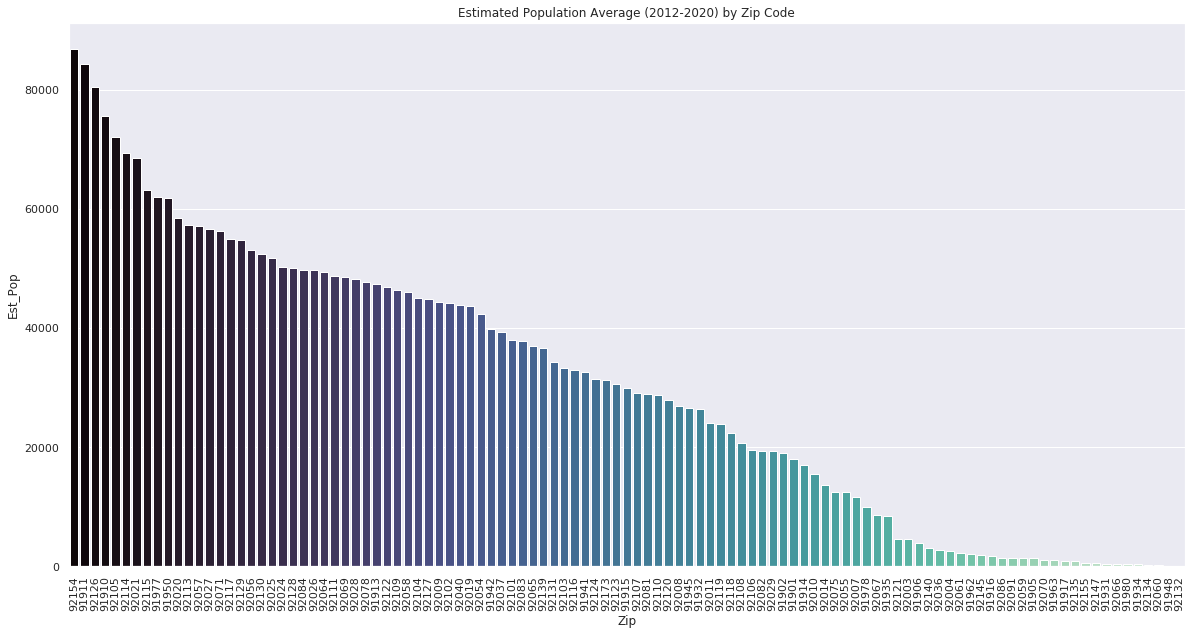

In [242]:
# Display top 20 most populated zip codes
plt.figure(figsize=(20, 10))
sns.set(font_scale = 1)

sns.barplot(data=zipCode_pop_avg,
            x=zipCode_pop_avg['Zip'],
            y=zipCode_pop_avg['Est_Pop'],
            order=zipCode_pop_avg['Zip'],
            palette="mako")
plt.title('Estimated Population Average (2012-2020) by Zip Code')
plt.xticks(rotation=90)

In [243]:
zipCode_pop_avg.tail()

,Zip,Est_Pop,MOE,Year
13,91934,345.555556,240.444444,2016.0
98,92134,205.444444,146.333333,2016.0
51,92060,140.000000,127.444444,2016.0
18,91948,53.333333,71.444444,2016.0
97,92132,0.000000,12.222222,2016.0


#### Group By Year (Overall Population Growth)

In [244]:
year_over_year_df = pop_df[['Year','Est_Pop']].groupby('Year').sum()
year_over_year_df

,Est_Pop
Year,
2012,3097524
2013,3134151
2014,3178607
2015,3218065
2016,3105642
2017,3278402
2018,3297495
2019,3310766
2020,3318619


In [245]:
year_over_year_df.diff(axis=0)

,Est_Pop
Year,
2012,NaN
2013,36627.0
2014,44456.0
2015,39458.0
2016,-112423.0
2017,172760.0
2018,19093.0
2019,13271.0
2020,7853.0


# Population Growth

In [254]:
fig = px.line(year_over_year_df, x=year_over_year_df.index, y='Est_Pop')

title_string = 'San Diego Population Over the Years'
fig.update_layout(title=title_string, title_x=0.5)
fig.show()

In [250]:
fig = px.line(year_over_year_df, x=year_over_year_df.index, y='Est_Pop', range_y=[3000000, 3500000])

title_string = 'San Diego Population Over the Years'
fig.update_layout(title=title_string, title_x=0.5)
fig.update_xaxes(tickangle=90)
fig.show()

In [252]:
pop_df.head(3)

,Zip,Est_Pop,MOE,Year,weather_station
0,91901,17034,968,2012,Campo
1,91902,17659,1031,2012,San Diego Brown Field
2,91905,1088,441,2012,Campo


# SDGE  EDA
Data is from [Data Source](https://energydata.sdge.com/)

# Gas

In [258]:
len(set(gas_df['ZipCode']))

81

In [259]:
gas_df['ZipCode'].min()

91901

In [260]:
gas_df['ZipCode'].max()

92173

In [263]:
gas_df.head(3)

,ZipCode,Year,Month,TotalCustomers,TotalTherms,AverageTherms
0,91901,2012,1,2711,148354,292
1,91901,2012,2,2704,138102,283
2,91901,2012,3,2674,159852,309


In [262]:
gas_df.iloc[:,2:].describe()

,Month,TotalCustomers,TotalTherms,AverageTherms
count,9452.000000,9452.000000,9.452000e+03,9452.000000
mean,6.461172,10496.070355,6.279289e+05,229.759839
std,3.485155,5956.745717,1.113452e+06,541.550896
min,1.000000,101.000000,1.647000e+03,6.000000
25%,3.000000,5690.750000,1.512152e+05,25.000000
50%,6.000000,10440.000000,3.255510e+05,138.000000
75%,10.000000,15203.250000,7.038100e+05,302.000000
max,12.000000,25256.000000,3.769568e+07,17320.000000


## Zip Codes with the Most of "____"

In [265]:
grouped_by_zip = gas_df.groupby(['ZipCode']).mean().iloc[:,2:].reset_index()
grouped_by_zip.head()

,ZipCode,TotalCustomers,TotalTherms,AverageTherms
0,91901,2134.846154,192333.572650,257.888889
1,91902,4983.871795,276257.299145,58.282051
2,91910,20174.786325,814509.358974,39.076923
3,91911,16565.008547,927166.529915,257.427350
4,91913,14781.572650,570419.316239,249.384615


#### Total Customers by Zip

In [266]:
total_customers_by_zip = grouped_by_zip.sort_values(by=['TotalCustomers'], ascending=False).reset_index(drop=True)
total_customers_by_zip.head()

,ZipCode,TotalCustomers,TotalTherms,AverageTherms
0,92126,20194.914530,791086.341880,44.213675
1,91910,20174.786325,814509.358974,39.076923
2,92128,19439.145299,787872.760684,384.316239
3,92130,19100.598291,996003.692308,553.948718
4,92056,18307.837607,822045.581197,59.128205


In [267]:
zip_code_customer_count_rankings = pd.DataFrame({'ZipCode': total_customers_by_zip['ZipCode'],
              'Cust_Rank': total_customers_by_zip.index})

zip_code_customer_count_rankings.head(3)

,ZipCode,Cust_Rank
0,92126,0
1,91910,1
2,92128,2


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]),
 <a list of 81 Text xticklabel objects>)

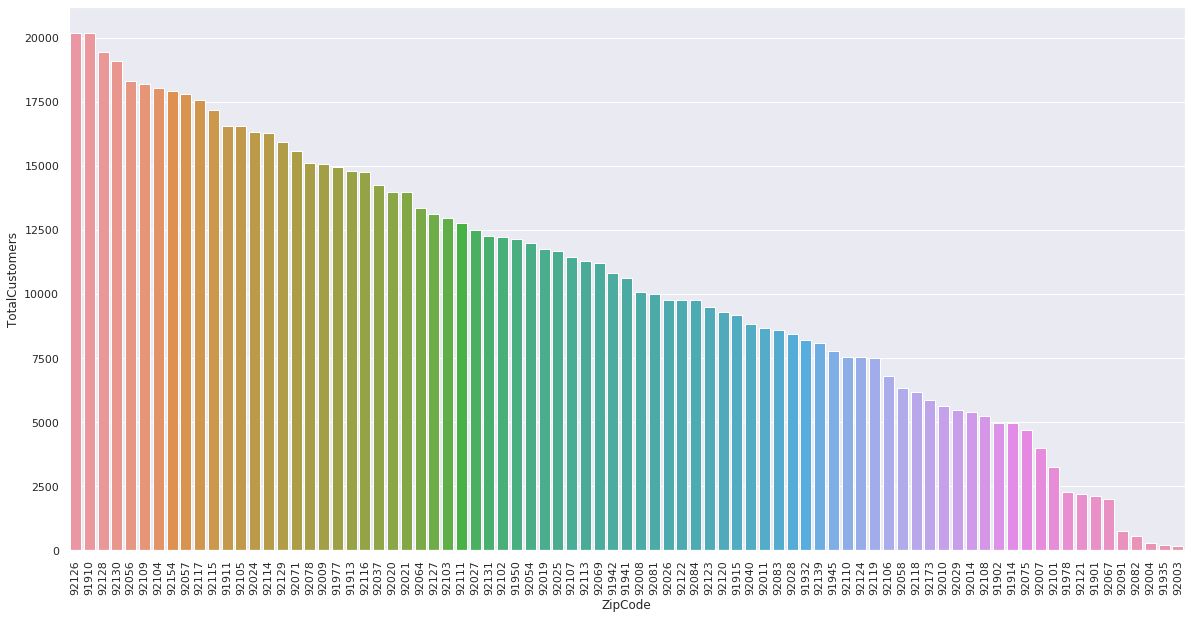

In [268]:
# Display top 20 most populated zip codes
plt.figure(figsize=(20, 10))

sns.barplot(data=total_customers_by_zip[:20],
            x=total_customers_by_zip['ZipCode'],
            y=total_customers_by_zip['TotalCustomers'],
            order=total_customers_by_zip['ZipCode'])
plt.xticks(rotation=90)

#### Total Therms by Zip

In [269]:
total_therms_by_zip = grouped_by_zip.sort_values(by=['TotalTherms'], ascending=False).reset_index(drop=True)
total_therms_by_zip.head()

,ZipCode,TotalCustomers,TotalTherms,AverageTherms
0,92121,2205.410256,2.420250e+06,1362.752137
1,92101,3248.401709,1.588036e+06,1179.837607
2,92037,14236.034188,1.193955e+06,83.529915
3,92020,13986.170940,1.117858e+06,223.666667
4,92025,11687.803419,1.051249e+06,236.213675


In [270]:
zip_code_thermal_rankings = pd.DataFrame({'ZipCode': total_therms_by_zip['ZipCode'],
              'Thermal_Rank': total_therms_by_zip.index})

zip_code_thermal_rankings.head()

,ZipCode,Thermal_Rank
0,92121,0
1,92101,1
2,92037,2
3,92020,3
4,92025,4


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]),
 <a list of 81 Text xticklabel objects>)

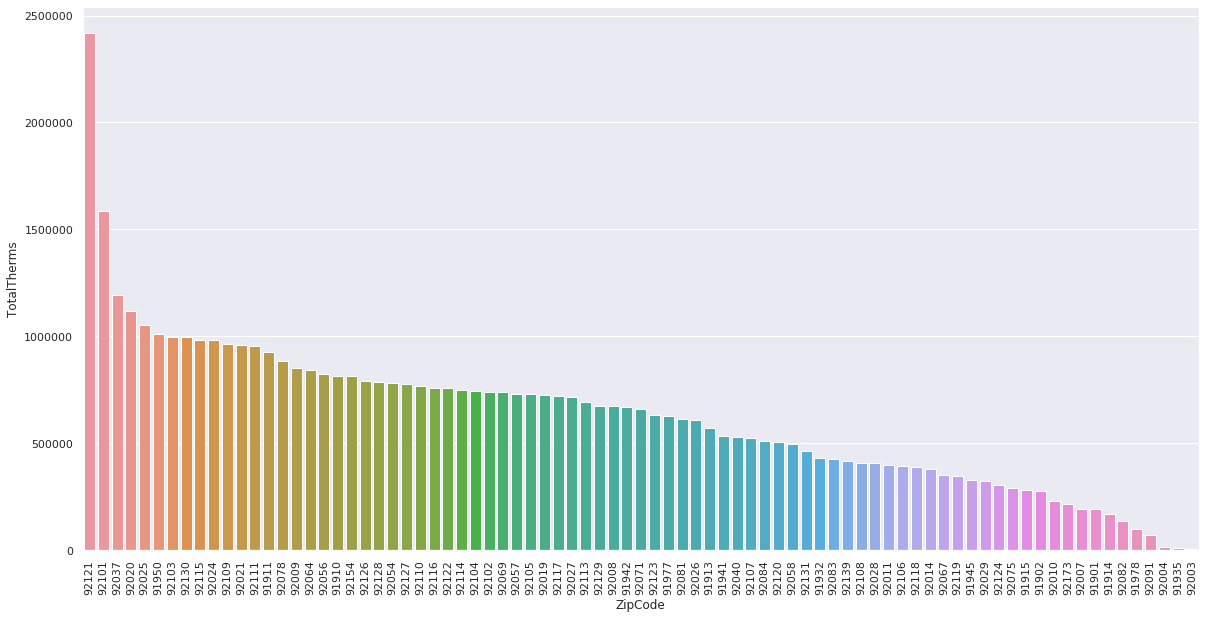

In [271]:
# Display top 20 most populated zip codes
plt.figure(figsize=(20, 10))

sns.barplot(data=total_therms_by_zip[:20],
            x=total_therms_by_zip['ZipCode'],
            y=total_therms_by_zip['TotalTherms'],
            order=total_therms_by_zip['ZipCode'])
plt.xticks(rotation=90)

#### Avg Total Therms by Avg Therms

In [272]:
avg_therms_by_zip_code = grouped_by_zip.sort_values(by=['AverageTherms'], ascending=False)

avg_therms_by_zip_code.head()

,ZipCode,TotalCustomers,TotalTherms,AverageTherms
68,92121,2205.410256,2.420250e+06,1362.752137
49,92101,3248.401709,1.588036e+06,1179.837607
76,92130,19100.598291,9.960037e+05,553.948718
19,92009,15060.068376,8.509332e+05,474.529915
69,92122,9770.504274,7.583543e+05,429.111111


In [273]:
zip_code_AVG_therm_rankings = pd.DataFrame({'ZipCode': avg_therms_by_zip_code['ZipCode'],
              'AVG_Therm_Rank': avg_therms_by_zip_code.index})

zip_code_AVG_therm_rankings.head()

,ZipCode,AVG_Therm_Rank
68,92121,68
49,92101,49
76,92130,76
19,92009,19
69,92122,69


## Zip Code Ranking statistics

In [274]:
def dot_plot(df):
    # Make the PairGrid
  g = sns.PairGrid(df,
                  x_vars=df.columns[1:], y_vars=["ZipCode"],
                  height=10, aspect=.50)

  # Draw a dot plot using the stripplot function
  g.map(sns.stripplot, size=10, orient="h", jitter=False,
        palette="flare_r", linewidth=1, edgecolor="w")

  # Use the same x axis limits on all columns and add better labels
  g.set(xlim=(0, 82), xlabel="Ranking", ylabel="")

  # Use semantically meaningful titles for the columns
  titles = df.columns[1:]

  for ax, title in zip(g.axes.flat, titles):

      # Set a different title for each axes
      ax.set(title=title)

      # Make the grid horizontal instead of vertical
      ax.xaxis.grid(False)
      ax.yaxis.grid(True)

  sns.despine(left=True, bottom=True)

In [275]:
# Merge All Ranking Frames to compare Zip Code statistics
gas_zip_rankings_df = zip_code_customer_count_rankings.merge(zip_code_thermal_rankings, on='ZipCode')
gas_zip_rankings_df.head(3)

,ZipCode,Cust_Rank,Thermal_Rank
0,92126,0,20
1,91910,1,18
2,92128,2,21


In [276]:
gas_zip_rankings_df = gas_zip_rankings_df.merge(zip_code_AVG_therm_rankings, on='ZipCode')
gas_zip_rankings_df.head(3)

,ZipCode,Cust_Rank,Thermal_Rank,AVG_Therm_Rank
0,92126,0,20,72
1,91910,1,18,2
2,92128,2,21,74


#### Let's only look at the top 20 

#### Consumption in relationship to Total Customers

In [278]:
date_columns = ['Month','Year']
gas_df['Full_date'] = gas_df.loc[:,date_columns].apply(lambda x: '/'.join(x.values.astype(str)), axis='columns')
gas_df.head(3)

,ZipCode,Year,Month,TotalCustomers,TotalTherms,AverageTherms,Full_date
0,91901,2012,1,2711,148354,292,1/2012
1,91901,2012,2,2704,138102,283,2/2012
2,91901,2012,3,2674,159852,309,3/2012


In [279]:
group_by_date = gas_df.groupby('Full_date').sum().reset_index()

group_by_date['Full_date'] = pd.to_datetime(group_by_date['Full_date'])
group_by_date = group_by_date.sort_values(by='Full_date')
group_by_date.head()

,Full_date,ZipCode,Year,Month,TotalCustomers,TotalTherms,AverageTherms
0,2012-01-01,7456223,162972,81,1050238,59824421,19446
40,2012-02-01,7456223,162972,162,1043206,53533184,15695
50,2012-03-01,7456223,162972,243,1045453,51527680,18120
60,2012-04-01,7456223,162972,324,1037553,58511766,16203
70,2012-05-01,7456223,162972,405,1034542,48358237,15182


In [280]:
fig = px.line(group_by_date, x="Full_date", y="TotalTherms")
fig.show()

## Gas Final Formation

In [281]:
gas_df.head(3)

,ZipCode,Year,Month,TotalCustomers,TotalTherms,AverageTherms,Full_date
0,91901,2012,1,2711,148354,292,1/2012
1,91901,2012,2,2704,138102,283,2/2012
2,91901,2012,3,2674,159852,309,3/2012


In [282]:
# group by the following to combine commercial & residential consumers into 1 row
gas_df = gas_df.groupby(['ZipCode', 'Year','Month']).sum()
gas_df = gas_df.reset_index()
gas_df.head(3)

,ZipCode,Year,Month,TotalCustomers,TotalTherms,AverageTherms
0,91901,2012,1,2711,148354,292
1,91901,2012,2,2704,138102,283
2,91901,2012,3,2674,159852,309


# Electric

In [284]:
date_columns = ['Month','Year']
elect_df['Full_date'] = elect_df.loc[:,date_columns].apply(lambda x: '/'.join(x.values.astype(str)), axis='columns')
elect_df.head(3)

,ZipCode,Year,Month,TotalCustomers,TotalkWh,AveragekWh,Full_date
0,91901,2012,1,595,178335,603,1/2012
1,91901,2012,2,736,572185,1555,2/2012
2,91901,2012,3,1866,1180728,1776,3/2012


In [285]:
elect_years = elect_df.groupby('Full_date').sum().reset_index()

elect_years['Full_date'] = pd.to_datetime(elect_years['Full_date'])
elect_years = elect_years.sort_values(by='Full_date')
elect_years.head()

,Full_date,ZipCode,Year,Month,TotalCustomers,TotalkWh,AveragekWh
0,2012-01-01,6995918,152912,76,41783,9591304,32201
40,2012-02-01,7364219,160960,160,69489,24872248,55085
50,2012-03-01,7640196,166996,249,162080,90991855,94749
60,2012-04-01,7548290,164984,328,176359,180347430,195819
70,2012-05-01,7824286,171020,425,184623,236274347,250942


In [286]:
elect_years.dtypes

Full_date         datetime64[ns]
ZipCode                    int64
Year                       int64
Month                      int64
TotalCustomers             int64
TotalkWh                   int64
AveragekWh                 int64
dtype: object

In [289]:
fig = px.line(year_over_year_df, x=year_over_year_df.index, y='Est_Pop', range_y=[3000000, 3500000])

title_string = 'San Diego Population Over the Years'
fig.update_layout(height=800,width=1000, title=title_string, title_x=0.5)

fig.update_xaxes(tickangle=90)
fig.show()

In [290]:
fig = px.line(elect_years, x="Full_date", y="TotalkWh",
              labels={
                     "Full_date": "Years"
                 })

title_string = 'Electricity Consumption'
fig.update_layout(height=800,width=2000, title=title_string, title_x=0.5)
fig.show()

Data is from.  

[https://www.energy.ca.gov/files/zev-and-infrastructure-stats-data](https://www.energy.ca.gov/files/zev-and-infrastructure-stats-data)

# EDA for Vehicle Sales Data

In [293]:
veh_df.describe()

,Year,ZIP,#_vehicles
count,12744.000000,12744.000000,12744.000000
mean,2015.340552,92060.988230,1883.581058
std,3.106370,81.655043,6726.591164
min,2010.000000,91901.000000,1.000000
25%,2013.000000,92011.000000,5.000000
50%,2015.000000,92071.000000,37.000000
75%,2018.000000,92123.000000,424.250000
max,2020.000000,92199.000000,66237.000000


In [294]:
#determine the number of unique values for each column
dict=[]
for i in veh_df.columns:
  print(f'{i} has {veh_df[i].nunique()} unique values')

Year has 11 unique values
Fuel has 10 unique values
ZIP has 188 unique values
#_vehicles has 2403 unique values


In [295]:
#determine the unique values for the year and fuel columns
print("Year can take on:\n", veh_df.Year.value_counts(), "\n")
print("Fuel can take on:\n", veh_df.Fuel.value_counts(), "\n")

Year can take on:
 2020    1308
2019    1302
2018    1290
2017    1255
2016    1203
2015    1165
2014    1142
2013    1117
2012    1086
2011    1023
2010     853
Name: Year, dtype: int64 

Fuel can take on:
 Gasoline           2040
Flex Fuel          1925
Diesel             1869
Gasoline Hybrid    1868
Bio Diesel         1267
PHEV               1170
Electric           1169
Natural Gas         918
Propane             323
Hydrogen            195
Name: Fuel, dtype: int64 



### Identifying Null Values


In [296]:
#check for missing data in the dataset
veh_df.isnull().sum()

Year          0
Fuel          0
ZIP           0
#_vehicles    0
dtype: int64

# Plots and Visualizations

In [297]:
veh_type_count = veh_df.loc[:,['Fuel','#_vehicles']].groupby('Fuel').count()
veh_type_count = veh_type_count.sort_values('#_vehicles', ascending=False)
veh_type_count = veh_type_count.reset_index()
veh_type_count.head(3)

,Fuel,#_vehicles
0,Gasoline,2040
1,Flex Fuel,1925
2,Diesel,1869


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

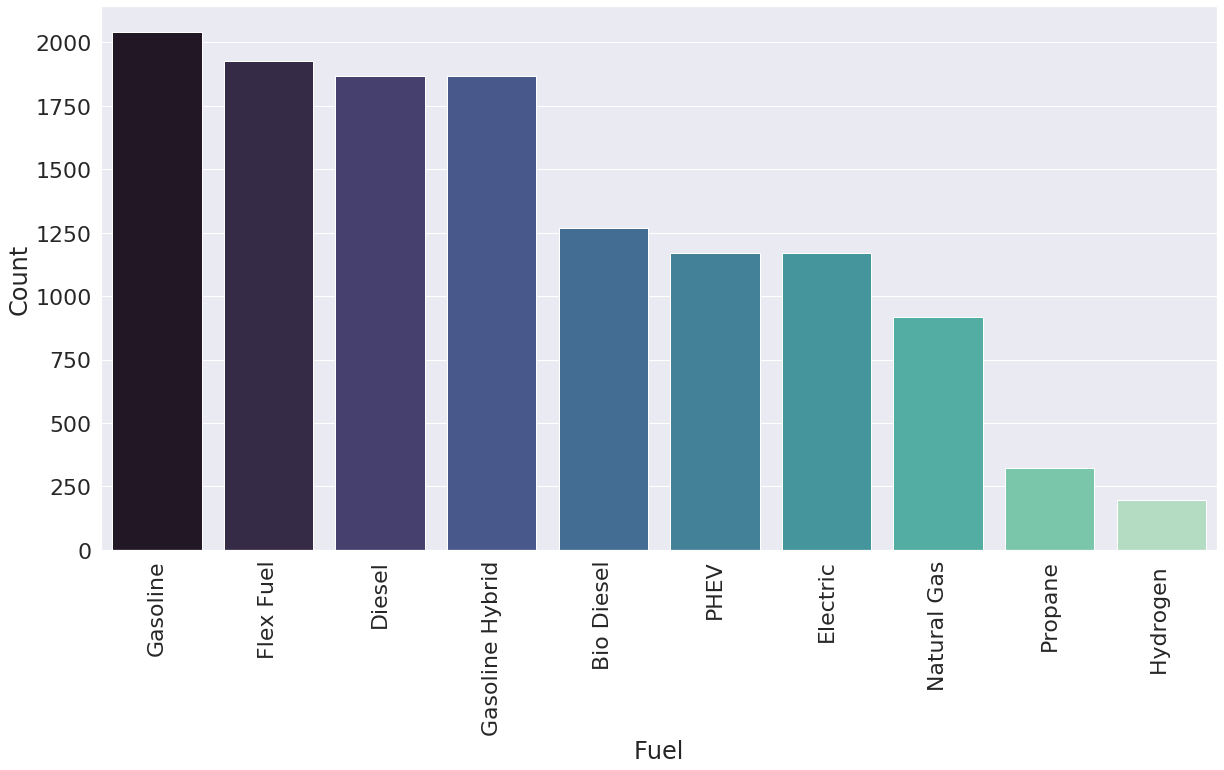

In [298]:
# Display top 20 most populated zip codes
plt.figure(figsize=(20, 10))
sns.set(font_scale = 2)

sns.barplot(data=veh_type_count,
            x=veh_type_count['Fuel'],
            y=veh_type_count['#_vehicles'],
            palette="mako")
plt.ylabel('Count')

plt.xticks(rotation=90)

In [299]:
veh_type_count = veh_df.loc[:,['Year','Fuel','#_vehicles']].groupby(['Year','Fuel']).count()
veh_type_count = veh_type_count.reset_index()
veh_type_count

,Year,Fuel,#_vehicles
0,2010,Bio Diesel,41
1,2010,Diesel,169
2,2010,Electric,16
3,2010,Flex Fuel,177
4,2010,Gasoline,186
...,...,...,...
99,2020,Gasoline Hybrid,170
100,2020,Hydrogen,53
101,2020,Natural Gas,87
102,2020,PHEV,148


##### Distribution Visualizations


In [300]:
# #frequency distribution Year
# sns.countplot(data = veh_df, x = 'Year')

# #frequency distribution Zipcode
# sns.countplot(data = veh_df, x = 'ZIP')

In [301]:
veh_year = veh_df.loc[:,veh_df.columns !='ZIP'].groupby(['Year','Fuel']).sum()
veh_year = veh_year.reset_index()
veh_year.head(3)

,Year,Fuel,#_vehicles
0,2010,Bio Diesel,83
1,2010,Diesel,33492
2,2010,Electric,29


#### All Fuel

In [302]:
fig.update_layout(title=title_string, title_x=0.5)


In [303]:
title_string = 'Fuel Type Registration by Year'
fig = px.line(veh_year, x="Year", y="#_vehicles", color='Fuel')
fig.update_layout(height=800,width=2000, title=title_string, title_x=0.5)
fig.show()

In [304]:
set(veh_year['Fuel'])

{'Bio Diesel',
 'Diesel',
 'Electric',
 'Flex Fuel',
 'Gasoline',
 'Gasoline Hybrid',
 'Hydrogen ',
 'Natural Gas',
 'PHEV',
 'Propane'}

In [305]:
non_mainstram = ['Natural Gas',
                'Hydrogen ',
                'Bio Diesel',
                'Electric',
                'PHEV',
                'Propane']
              
other_fuels_df = veh_year.loc[veh_year['Fuel'].isin(non_mainstram),:]

title_string = 'Fuel Type Registration by Year (excluding Diesel, Gas, and Flex Fuel)'
fig = px.line(other_fuels_df, x="Year", y="#_vehicles", color='Fuel')
fig.update_layout(height=800,width=2000, title=title_string, title_x=0.5)
fig.show()


In [306]:
non_mainstram = [
                #  'Natural Gas',
                'Hydrogen ',
                # 'Bio Diesel',
                # 'Electric',
                # 'PHEV',
                # 'Propane'
                 ]
              
hydro_df = veh_year.loc[veh_year['Fuel'].isin(non_mainstram),:]

title_string = 'Hydrogen registration trend'
fig = px.line(hydro_df, x="Year", y="#_vehicles", color='Fuel')
fig.update_layout(height=800,width=2000, title=title_string, title_x=0.5)
fig.show()


#Further analysis for Fuel


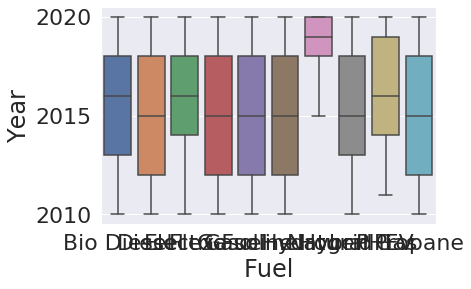

In [307]:
#box plot for fuel vs Year
sns.boxplot(x='Fuel', y='Year', data=veh_df)
plt.show()

In [ ]:
# Correlation Analysis

#correlation plot to determine correlations between variables.
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(veh_df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Vehicle Data Set Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

In [ ]:
veh_df.head()

In [ ]:
#frequency distribution annual_premium
sns.distplot(veh_df['Fuel'], hist=True, kde=True,
             bins=int(180/5), color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

# Exploration of Clean & Melted Dataset

Now it is time to utilize Data Wrangler Flow Files to merge datasets and create basline models for both electricity and gas.